In [23]:
# !pip install xlrd
# !pip install thefuzz
# !pip install geopandas
# !pip install geodatasets

In [24]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import seaborn as sns

# import geopandas as gpd
# import geodatasets as gds

from thefuzz import fuzz
from thefuzz import process
import re

from functions import *

# url = r"C:\Users\PapaYaga\Documents\GitHub\Projects\GSAF5.xls"
url = r"GSAF5.xls"
sharks_df = pd.DataFrame(pd.read_excel(url))


In [25]:
sharks_df.columns = pd.Series(sharks_df.columns).apply(clean_cols)
sharks_df["Date"] = sharks_df["Date"].apply(lambda x: clean_date(x))
# sharks_df["Year"] = sharks_df["Date"].apply(lambda x: re.findall("[0-9]{4}", x)[0] if x else x)
sharks_df["Year"] = sharks_df["Year"].apply(lambda x: str(x).replace(".0",""))
sharks_df["Months"] = sharks_df["Date"]
sharks_df["Months"] = extract_m(sharks_df["Months"])
sharks_df["Date"] = pd.to_datetime(sharks_df["Date"],format="mixed", errors="coerce")
sharks_df.set_index(["Date"], inplace=True, drop=True)

In [26]:
sharks_df["Type"] = clean_type(sharks_df["Type"])
sharks_df["Country"] = sharks_df["Country"].apply(clean_ctr)
sharks_df["State"] = sharks_df["State"].apply(clean_ctr)

In [27]:
sharks_rdx = sharks_df[["Year","Type","Country","State","Location","Activity","Name","Sex","Age","Injury","Time","Species","Months"]]
sharks_rdx.dropna(thresh=7, inplace=True)
sharks_rdx.sort_index(ascending=False, inplace=True)
sharks_rdx.drop_duplicates(inplace=True)

In [28]:
state_amount = sharks_rdx.groupby(["Country"])["State"].size().sort_values().tail(15)
state_amount_x = sharks_rdx["Country"].value_counts().sort_values().tail(15)

In [30]:
normalise_sex(sharks_rdx)
sharks_rdx["Activity"] = sharks_rdx["Activity"].fillna('Undisclosed')
activities = []

for i in sharks_rdx["Activity"]:
    lst = i.split()
    
    if len(lst) == 1:
        if lst[0].isalpha():          
            activities.append(lst[0])
        
activities = set(activities)

In [31]:
sharks_rdx["Activity"] = sharks_rdx["Activity"].apply(get_activity)

In [32]:
species_list = []

sharks_rdx["Species"] = sharks_rdx["Species"].fillna('Unknown')

for i in sharks_rdx["Species"]:
    
    if 'shark' in i.lower():
        split = i.lower().split()
        index = 0
        for i in split:
            if 'shark' in i:
                break
            else:
                index += 1
        if split[index -1].isalpha():
            species_list.append(split[index - 1])

In [33]:
pattern = r'(\d+(?:\.\d+)?)\s*m'

sharks_rdx["Shark Size"] = sharks_rdx["Species"].str.extract(pattern) + 'm'
sharks_rdx["Shark Size"].fillna('Unknown', inplace=True)
sharks_rdx["Species"] = sharks_rdx["Species"].apply(get_species)
sharks_rdx["Shark Size"] = sharks_rdx["Species"].apply(lambda x: get_species(x)[1])
sharks_rdx["Shark Size"] = sharks_rdx["Shark Size"].apply(classify_size)

In [34]:
sharks_rdx["Time"] = sharks_rdx["Time"].fillna('Unknown')
sharks_rdx["Time"] = sharks_rdx["Time"].apply(get_time)

In [ ]:
normalize_injury(sharks_rdx)

In [ ]:
name_unknown(sharks_rdx)

In [37]:
attacks = sharks_rdx.pivot_table(index="Injury", columns="Species", aggfunc="size").T.fillna(0).sort_values(by="Fatal", ascending=False)
attacks

Injury,Fatal,Minor,Moderate,No injury sustained,Severe,Unclassified,Unknown
Species,,,,,,,
Other,999.0,132.0,436.0,266.0,873.0,957.0,33.0
Tiger shark,396.0,105.0,350.0,381.0,828.0,623.0,8.0
Blue shark,12.0,2.0,10.0,18.0,14.0,45.0,5.0
Bull shark,9.0,2.0,26.0,4.0,37.0,20.0,0.0
Angel shark,2.0,0.0,0.0,0.0,0.0,0.0,0.0
White shark,2.0,0.0,5.0,4.0,5.0,8.0,0.0
Galapagos shark,1.0,2.0,0.0,0.0,0.0,1.0,0.0
Silky shark,1.0,0.0,1.0,1.0,1.0,0.0,0.0
Hammerhead shark,1.0,0.0,3.0,5.0,4.0,4.0,0.0


In [53]:
months = sharks_rdx.pivot_table(index="Months", columns="Species", aggfunc="size").T.fillna(0)
years = sharks_rdx.pivot_table(index="Year", columns="Species", aggfunc="size").T.fillna(0)

In [56]:
yeayears[years.index!="Tiger shark" & years.index!="Other"]

Year,0,1000,1500,1518,1543,1554,1555,1580,1595,1637,...,2018,2019,2020,2021,2022,2023,2024,5,77,nan
Species,,,,,,,,,,,,,,,,,,,,,
Angel shark,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Blacktip shark,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0
Blue shark,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Bronze whaler shark,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Bull shark,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,3.0,5.0,4.0,3.0,2.0,1.0,0.0,0.0,0.0
Caribbean reef shark,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,3.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Dogfish shark,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Galapagos shark,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Grey nurse shark,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
tiger = sharks_rdx[sharks_rdx["Species"]=="Tiger shark"]["Injury"].value_counts()

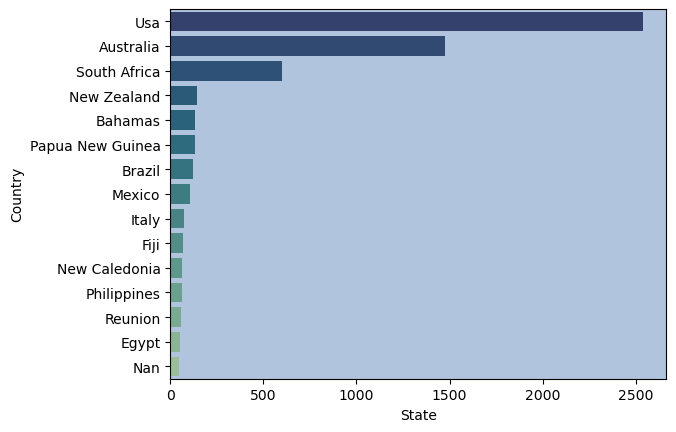

In [39]:

sns.set_style( {"grid.color":"black"}, rc = {'axes.facecolor': 'lightsteelblue'})
sns.barplot(x=state_amount, y=state_amount_x.index, palette="crest").invert_yaxis()

C:\Users\PariahJack\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


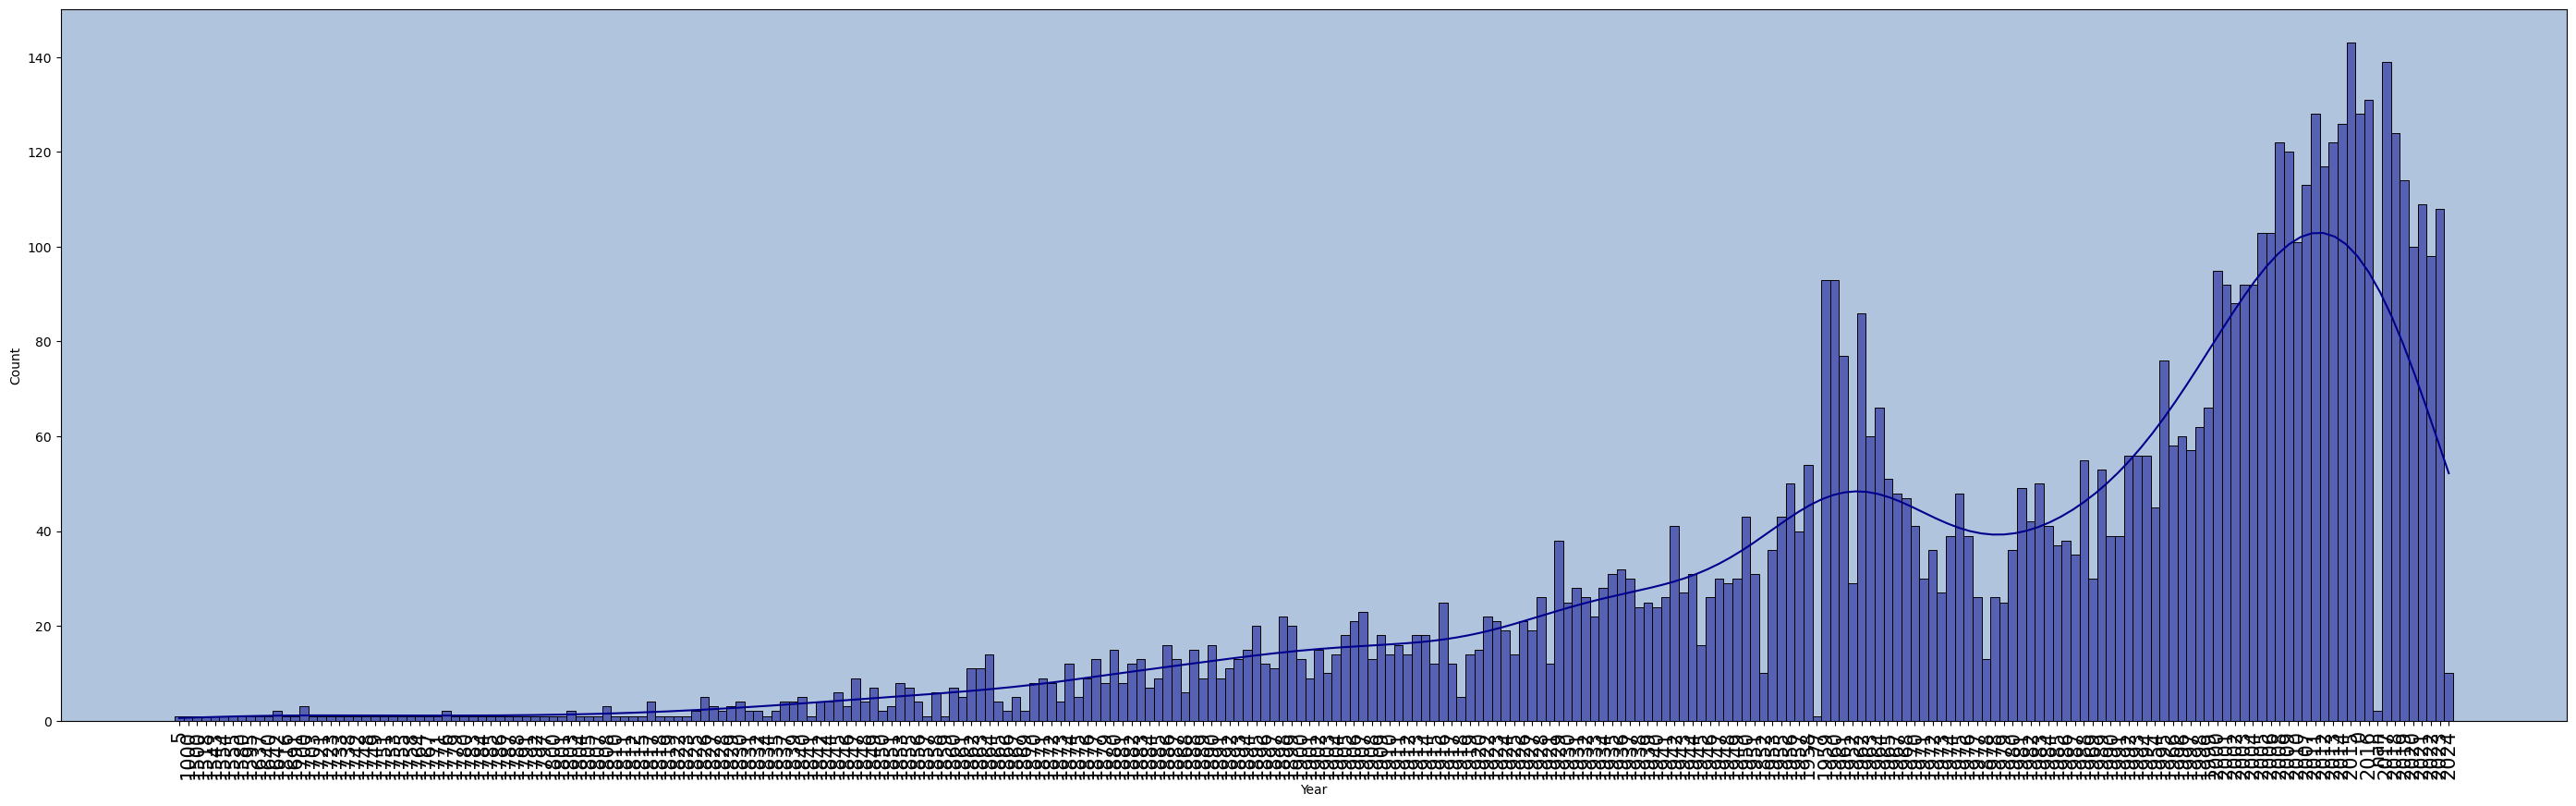

In [40]:
sns.set_style( {"grid.color":"gray"}, rc = {'axes.facecolor': 'lightsteelblue'})
plt.figure(figsize=(35, 10))
plt.xticks(size = 15, rotation = 90)
sns.histplot(sharks_rdx["Year"], color="darkblue", kde=True).invert_xaxis()

C:\Users\PariahJack\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Injury', ylabel='Count'>

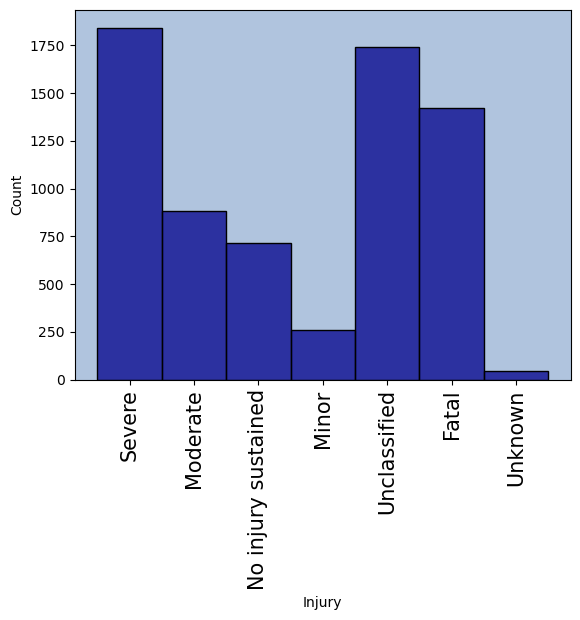

In [41]:
plt.xticks(size = 15, rotation = 90)
sns.histplot(sharks_rdx["Injury"], color="darkblue")

C:\Users\PariahJack\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


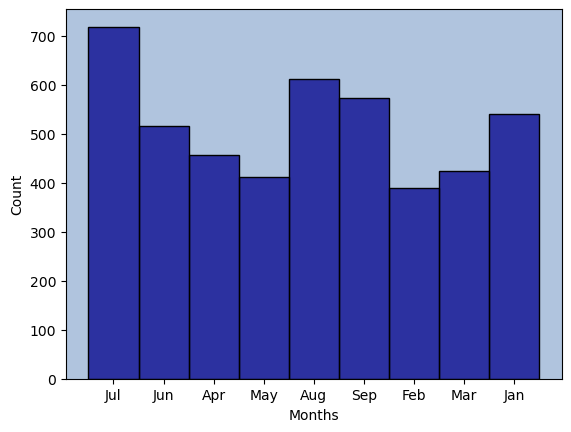

In [42]:
sns.histplot(sharks_rdx["Months"], color="darkblue").invert_xaxis()

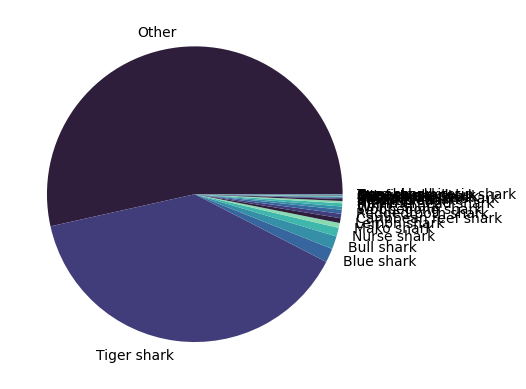

In [43]:
palette_color = sns.color_palette('mako') 
labels = sharks_rdx["Species"].value_counts().keys()

plt.pie(sharks_rdx["Species"].value_counts(), colors=palette_color, labels=labels)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

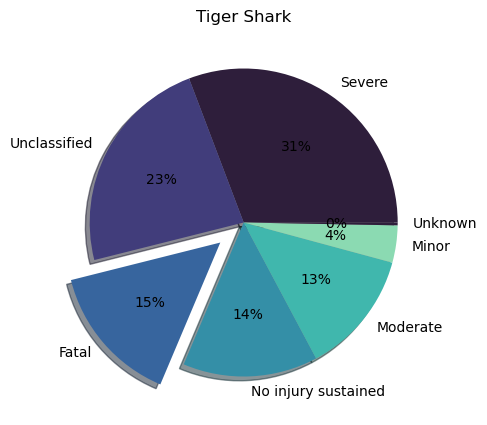

In [44]:
fig, ax = plt.subplots(figsize=(8, 5), subplot_kw=dict(aspect="equal"))
ax.pie(tiger, radius=1, labels=tiger.keys(),
       colors=palette_color, autopct="%.0f%%", explode=[0,0,0.2,0,0,0,0], shadow=True)

ax.set_title("Tiger Shark")
plt.show

<Axes: xlabel='Year', ylabel='Species'>

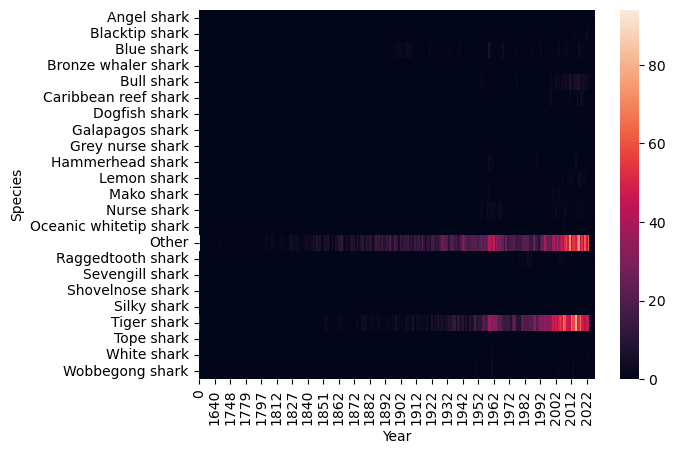

In [51]:
sns.heatmap(years)